In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,functional,Compose,Resize
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn.functional as F
# from torchvision.transforms
import math

In [4]:
# Helper to get the input size to the fully connected layer which is an output of the convolutional portion

def get_conv_output(inp,kernel_size=[5,5],padding=[0,0],dilation=[1,1],stride=[1,1]):
    h_out=((inp[0]+(2*padding[0]) - dilation[0]*(kernel_size[0]-1) -1)/stride[0]) + 1
    w_out=((inp[1]+(2*padding[1]) - dilation[1]*(kernel_size[1]-1) -1)/stride[1]) + 1
    return h_out,w_out

def get_pool_output(inp,kernel_size,padding=[0,0],dilation=[1,1],stride=None,ceil_mode=False):
    if stride == None:
        stride = kernel_size
    h_out=(inp[0] + 2*padding[0] - dilation[0]*(kernel_size[0] - 1) - 1)/stride[0]+1
    w_out=(inp[1] + 2*padding[1] - dilation[1]*(kernel_size[1] - 1) - 1)/stride[1]+1
    if ceil_mode:
        h_out=math.ceil(h_out)
        w_out=math.ceil(w_out)
    else:
        h_out=math.floor(h_out)
        w_out=math.floor(w_out)
    return h_out,w_out

a=get_pool_output(get_conv_output([64,64]),[2,2])
b=get_pool_output(get_conv_output(a),[2,2])
# b

In [3]:
transform=Compose([Resize((64,64)),ToTensor()])
imgloader_dataset=datasets.ImageFolder('data/train/',transform=transform)
imgloader_dataloader=DataLoader(imgloader_dataset,batch_size=10,shuffle=True)
classes=imgloader_dataset.classes

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [8]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2, 2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*13*13,500)
        self.fc2=nn.Linear(500,1000)
        self.output=nn.Linear(1000,10)
        
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.output(x)
        return x
        
        

In [10]:
mymodel=MyModel()
mymodel.to(device)
print(mymodel)

MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=10, bias=True)
)


In [11]:
optimizer = torch.optim.SGD(mymodel.parameters(), lr=0.01)
loss_fn=nn.CrossEntropyLoss()

In [12]:
for epoch in range(1,6):
    for batch_no,(X,y) in enumerate(imgloader_dataloader):
        X,y=X.to(device),y.to(device)
        optimizer.zero_grad()
        pred=mymodel(X)
        loss=loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        if batch_no%200==0:
            print(f'Epoch: {epoch} Batch: {batch_no+1} Loss: {loss}')
    

Epoch: 1 Batch: 1 Loss: 2.3037943840026855
Epoch: 1 Batch: 201 Loss: 2.301267623901367
Epoch: 1 Batch: 401 Loss: 2.3104281425476074
Epoch: 1 Batch: 601 Loss: 2.2904984951019287
Epoch: 1 Batch: 801 Loss: 2.299591541290283
Epoch: 1 Batch: 1001 Loss: 2.1915841102600098
Epoch: 1 Batch: 1201 Loss: 2.1098389625549316
Epoch: 1 Batch: 1401 Loss: 2.110503911972046
Epoch: 1 Batch: 1601 Loss: 2.1075282096862793
Epoch: 1 Batch: 1801 Loss: 2.409313917160034
Epoch: 1 Batch: 2001 Loss: 2.1264235973358154
Epoch: 1 Batch: 2201 Loss: 1.89630925655365
Epoch: 1 Batch: 2401 Loss: 1.9267774820327759
Epoch: 1 Batch: 2601 Loss: 1.7733659744262695
Epoch: 1 Batch: 2801 Loss: 2.071542978286743
Epoch: 1 Batch: 3001 Loss: 2.2319443225860596
Epoch: 1 Batch: 3201 Loss: 2.3597488403320312
Epoch: 1 Batch: 3401 Loss: 1.6647411584854126
Epoch: 1 Batch: 3601 Loss: 1.8839384317398071
Epoch: 1 Batch: 3801 Loss: 2.38122296333313
Epoch: 1 Batch: 4001 Loss: 1.6312048435211182
Epoch: 1 Batch: 4201 Loss: 1.755866289138794
Epoch

KeyboardInterrupt: 

Predicted Class: bird


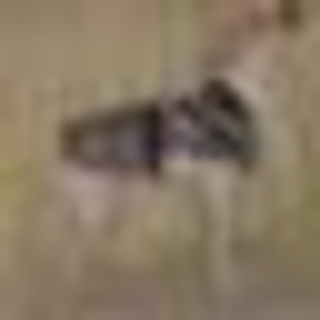

In [81]:
idx=7

samp=mymodel(X[idx].unsqueeze(0))
x=torch.max(samp,1)
print(f'Predicted Class: {classes[x[1]]}')

# IMAGE SHOW
imarray=X[idx].to('cpu').numpy()

# image pixels are  between 0-1 , multiply by 255 to change from 0 to 255
imarray = imarray * 255
# doesnt like floats or ints, change to unsigned integer
imarray = imarray.astype(np.uint8)
# doesnt like channels first, change to channels last
imarray=np.moveaxis(imarray,0,-1)

Image.fromarray(imarray).resize((320,320))